# SCC-ICMC-USP - 1st. Semester - 2023
# SCC5948/MAI5024. Data Science - Final Work – **03.** Training and Test

### Prof. PhD. Roseli Aparecida Francelin Romero

### Monitor: Diogo Godoi

Group Number: 12

Students:

1.   Leandro Marcos da Silva (**13702000**)
2.   Vinícius Andreghetti (**9898012**)


## Imports

In [1]:
# Imports
from imblearn.over_sampling import KMeansSMOTE
from pathlib import Path
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from utils import split_X_y # utils.py

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import warnings
import xgboost as xgb
import pycaret


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

## Functions

In [2]:
def plot_roc_curve(model, fpr, tpr, roc_auc, k,
                   save_figure=False, reports_path=None, file_name=None):
    # Config the plot
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calculate the mean ROC
    int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # Plot all ROC curves for each fold and the average ROC curve
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i + 1}, Area: {roc_auc[i]:.5f}')
    
    plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.5f} (+/- {np.std(roc_auc)*2:.5f})')

    # Plot the graph
    plt.legend(prop={'size': 16})
    # Save the ROC curve
    plt.savefig(f'{reports_path}images/{file_name}-roc_curve.png')
    plt.show() # Show the plot



def plot_confusion_matrix(y_true, y_pred, class_names, normalized,
                          save_figure=False, reports_path=None, file_name=None):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalized)
    # Confusion matrix display
    cm_p = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(7,7)) # Plot size
    plt.rcParams.update({'font.size': 14}) # Font size
    cm_p.plot(ax=ax) # Confusion matrix plot show
    
    if save_figure == True: # Save figure
        plt.savefig(f'{reports_path}images/{file_name}-cm.png')
        
    # Return confusion matrix
    return cm



def classification_with_report(model, X, y, k, class_names, save_report=False,
                               reports_path=None, file_name=None, verbose=True):
    # Lists
    fpr, tpr, roc_auc = [], [], []
    original_label, predicted_label, predicted_proba = [], [], []
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(k)
    
    # Time counting
    start = time()
    
    # Train and test the model for each 'k' fold in all the data
    for train_index, test_index in skf.split(X,y):
        model.fit(X.iloc[train_index], y[train_index])
        y_pred_probability = model.predict_proba(X.iloc[test_index])

        # Predict to generate classification report
        y_pred = model.predict(X.iloc[test_index])
        predicted_label.extend(y_pred)
        original_label.extend(y[test_index])

        # Compute micro-average ROC curve and ROC area
        temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))
     
    # Total time spent on training
    total_time = time() - start

    if verbose == True: # Show results
        # Results
        print('\t\t\tClassification Report\n\n')
        print(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
        print('Accuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
        print('F1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
        print('Precision: ' + str(round(precision_score(original_label, predicted_label), 5)))
        print('Recall: ' + str(round(recall_score(original_label, predicted_label), 5)))
        print('AUC: ' + str(round(np.mean(roc_auc), 5)))
        print('Total Time: ' + str(round(total_time, 5)) + ' seconds')
        print('Confusion Matrix:\n')
        # Plot the ROC curve
        plot_roc_curve(model, fpr, tpr, roc_auc, k)
        # Plot the confusion matrix
        _ = plot_confusion_matrix(original_label, predicted_label, class_names, None)

    if save_report == True: # Save report
        # file_name (without extension)
        with open(reports_path + file_name + '.txt', 'a+') as f:
            f.write(type(model).__name__ + '\n ')
            f.write(str(model))
            f.write('\n\n\n')
            f.write('\t\t\tClassification Report\n\n')
            f.write(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
            f.write('\n\nAccuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
            f.write('\n\nF1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
            f.write('\n\nPrecision: ' + str(round(precision_score(original_label, predicted_label), 5)))
            f.write('\n\nRecall: ' + str(round(recall_score(original_label, predicted_label), 5)))
            f.write('\nAUC: ' + str(round(np.mean(roc_auc), 5)))
            f.write('\nTotal Time: ' + str(round(total_time, 5)) + ' seconds\n\n')
            # Save the ROC curve
            plot_roc_curve(model, fpr, tpr, roc_auc, k,
                           save_figure=True, reports_path=reports_path, file_name=file_name)
            # Save the confusion matrix
            _ = plot_confusion_matrix(original_label, predicted_label, class_names, None,
                                      save_figure=True, reports_path=reports_path, file_name=file_name)

    return model # Return trained model



def objective(trial, X, y, k):
    params = { # Hyperparameters that will be optimized
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(k)
    scores = np.empty(k) # Save score of each fold

    # Train and validation the model for each 'k' fold
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params) # Start model
        # Train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
        )

        # Predict the values based on the F1-score
        preds = model.predict(X_val)
        scores[idx] = f1_score(y_val, preds)

    return np.mean(scores)



def report_model(model, X, y, class_names, normalized='true'):
    # Predict to generate report
    y_pred = model.predict(X)

    # Results
    print('\t\t\tClassification Report\n\n')
    print(classification_report(y, y_pred, target_names=class_names, digits=5))

    # Confusion matrix
    print('\nConfusion Matrix:\n')
    cm = plot_confusion_matrix(y, y_pred, class_names, normalized)
    # True Negative (TN)
    tn = cm[0][0]
    # False Negative (FN)
    fn = cm[1][0]
    # True Positive (TP)
    tp = cm[1][1]
    # False Positive (FP)
    fp = cm[0][1]
    # True Positive Rate (TRP)
    tpr = tp / (tp + fn)
    # False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    print(f'True Positive Rate (TPR): {round(tpr, 5)}')
    print(f'False Positive Rate (FPR): {round(fpr, 5)}')


def save_object(obj, file_name):
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(obj, f) # Save object with .pkl extension


        
def load_object(file_name):
    with open(f'{file_name}.pkl', 'rb') as f:
        loaded_obj = pickle.load(f) # Load object saved as .pkl
    
    return loaded_obj # Return loaded object



def lgb_plot_importance(booster, figsize, **kwargs):    
    # Create figure with size defined
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Bar chart with the importance of features
    return lgb.plot_importance(booster=booster, ax=ax, **kwargs)



def optimize_save_lgb(X, y, n_trials, k, models_path, reports_path, column_set):
    # Optimize LightGBM hyperparameters (selected algorithm)
    study = optuna.create_study(direction="maximize", study_name="lightgbm")
    func = lambda trial: objective(trial, X, y, k)
    # Setting the logging level CRITICAL
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(func, n_trials=n_trials, n_jobs=-1)

    # Save the best parameters in a .pkl file
    save_object(study.best_params, f'{models_path}params_lgb_{column_set}')
    
    # Load the best parameters
    best_params = load_object(f'{models_path}params_lgb_{column_set}')
    
    for i in range(3): # Run three times to average the execution time
        # LightGBM (optimized)
        model = lgb.LGBMClassifier(**best_params)
        model = classification_with_report(model, X, y, k, ['Normal', 'Evil Twin'],
                                           save_report=True, reports_path=reports_path,
                                           file_name=f'lgb_{column_set}_optimized', verbose=False)
        
    # Save optimized LightGBM model
    save_object(model, f'{models_path}lgb_{column_set}_optimized')
    # Load optimized LightGBM model
    model = load_object(f'{models_path}lgb_{column_set}_optimized')
    
    # Return the trained model
    return model



def get_df_column_set(df, numeric_columns, column_name):
    # DataFrame with column set
    return df[numeric_columns + list(df.filter(regex=column_name).columns)]

## Main


In [3]:
# General path
path = f'{str(Path.home())}/EvilTwin_detection/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'
# Path to save the models
models_path = f'{path}/models/'
# Path to save results
reports_path = f'{path}/reports/'

# Load pre-processed training dataset
train_df = pd.read_csv(preprocessed_data_path + 'train_data.csv')
# Load pre-processed test dataset
test_df = pd.read_csv(preprocessed_data_path + 'test_data.csv')

In [4]:
# Split train data into X and y
X_train, y_train = split_X_y(train_df)
# Split test data into X and y
X_test, y_test = split_X_y(test_df)

# Balance train data with SMOTE
X_res, y_res = KMeansSMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

In [5]:
%%capture
# Not plot show

for i in range(3): # Run the algorithms three times to average the execution time
    # Compare algorithms
    models = dict() # Create dictionary to save each model

    # Decision Tree (default)
    models['dt'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
    # Random Forest (default)
    models['rf'] = RandomForestClassifier(random_state=RANDOM_STATE)
    # Gaussian Naive Bayes (default)
    models['nb'] = GaussianNB()
    # Multi-Layer Perceptron (default)
    models['mlp'] = MLPClassifier(random_state=RANDOM_STATE)
    # XGBoost (default)
    models['xgb'] = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_STATE)
    # LightGBM (default)
    models['lgb'] = lgb.LGBMClassifier(random_state=RANDOM_STATE)

    for model_acronym in models.keys(): # Train and validate each dataset in each algorithm
        _ = classification_with_report(models[model_acronym], X_res, y_res, 5, ['Normal', 'Evil Twin'],
                                       save_report=True, reports_path=reports_path,
                                       file_name=f'{model_acronym}_all', verbose=False)

In [6]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res, y_res, 10, 5, models_path, reports_path, 'all')

[I 2023-05-11 14:49:58,635] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.24830444672357338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24830444672357338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.146957358176546e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.146957358176546e-06
[LightGBM] [Warning] bagging_fraction is set=0.32020075112747376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32020075112747376
[LightGBM] [Warning] lambda_l1 is set=1.5422866055453476e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5422866055453476e-08[LightGBM] [Warning] feature_fraction is set=0.45036754965571024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45036754965571024
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15

[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] feature_fraction is set=0.8437216001701568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8437216001701568
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=0.05915079487127891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05915079487127891
[LightGBM] [Warning] bagging_fraction is set=0.3967333875300221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3967333875300221
[LightGBM] [Warning] lambda_l1 is set=0.054085616481610636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054085616481610636
[LightGBM] [Warning] feature_fraction is set=0.9619036988627345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9619036988627345
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.35209679666909

[LightGBM] [Warning] feature_fraction is set=0.10376998825378712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10376998825378712
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.9380242852322087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9380242852322087
[LightGBM] [Warning] bagging_fraction is set=0.6038730615218263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6038730615218263
[LightGBM] [Warning] lambda_l1 is set=2.4889518508104716e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4889518508104716e-05
[LightGBM] [Warning] feature_fraction is set=0.8437216001701568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8437216001701568
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=0.05915079

[LightGBM] [Warning] feature_fraction is set=0.20147380455710984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20147380455710984
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.0018302201632394816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018302201632394816
[LightGBM] [Warning] bagging_fraction is set=0.657372888954874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.657372888954874
[LightGBM] [Warning] lambda_l1 is set=0.025532795445919115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025532795445919115
[LightGBM] [Warning] feature_fraction is set=0.10376998825378712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10376998825378712
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.938024

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

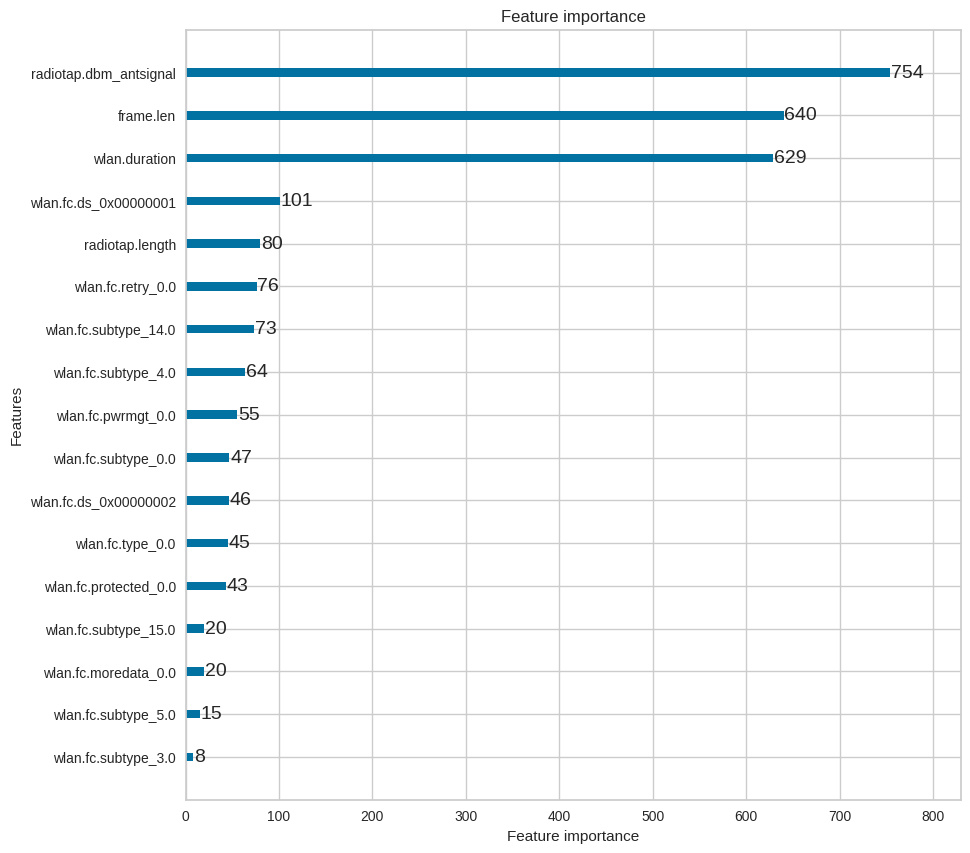

In [7]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99996   0.99353   0.99673     24272
   Evil Twin    0.77410   0.99814   0.87196       539

    accuracy                        0.99363     24811
   macro avg    0.88703   0.99584   0.93435     24811
weighted avg    0.99505   0.99363   0.99402     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99814
False Positive Rate (FPR): 0.00647


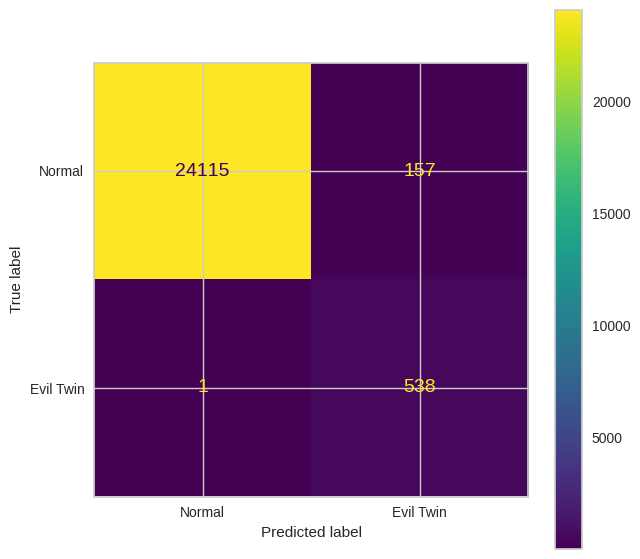

In [8]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test, y_test, ['Normal', 'Evil Twin'], None)

### Training and test with column set

In [9]:
# Numeric columns
numeric_columns = ['frame.len', 'radiotap.dbm_antsignal', 'wlan.duration']

* **Set 1** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.subtype*:

In [10]:
# Select column set (wlan.fc.subtype)
X_res_set_1 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.subtype')
X_test_set_1 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.subtype')

In [11]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_1, y_res, 10, 5, models_path, reports_path, 'set_1')

[LightGBM] [Warning] feature_fraction is set=0.4353326041359066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4353326041359066
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.2763415718755642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2763415718755642e-07
[LightGBM] [Warning] bagging_fraction is set=0.46634700670914353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46634700670914353
[LightGBM] [Warning] lambda_l1 is set=1.8068624985412648e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8068624985412648e-08
[LightGBM] [Warning] feature_fraction is set=0.5596237861328586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596237861328586
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.0338

[LightGBM] [Warning] feature_fraction is set=0.4353326041359066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4353326041359066
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.2763415718755642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2763415718755642e-07
[LightGBM] [Warning] bagging_fraction is set=0.46634700670914353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46634700670914353
[LightGBM] [Warning] lambda_l1 is set=1.8068624985412648e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8068624985412648e-08
[LightGBM] [Warning] feature_fraction is set=0.38143342353064036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38143342353064036
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=1.

[LightGBM] [Warning] feature_fraction is set=0.6715702685746108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715702685746108
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=0.0002550494118793937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002550494118793937
[LightGBM] [Warning] bagging_fraction is set=0.2922258141007772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2922258141007772
[LightGBM] [Warning] lambda_l1 is set=6.289241579002062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.289241579002062e-08
[LightGBM] [Warning] feature_fraction is set=0.4156783126683433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4156783126683433
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=8.495503

[LightGBM] [Warning] feature_fraction is set=0.8490286800234567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8490286800234567
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.26229929749343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.26229929749343
[LightGBM] [Warning] bagging_fraction is set=0.36403105507180034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36403105507180034
[LightGBM] [Warning] lambda_l1 is set=0.02877086657779228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02877086657779228
[LightGBM] [Warning] feature_fraction is set=0.4353326041359066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4353326041359066
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.2763415718755642e-07, 

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

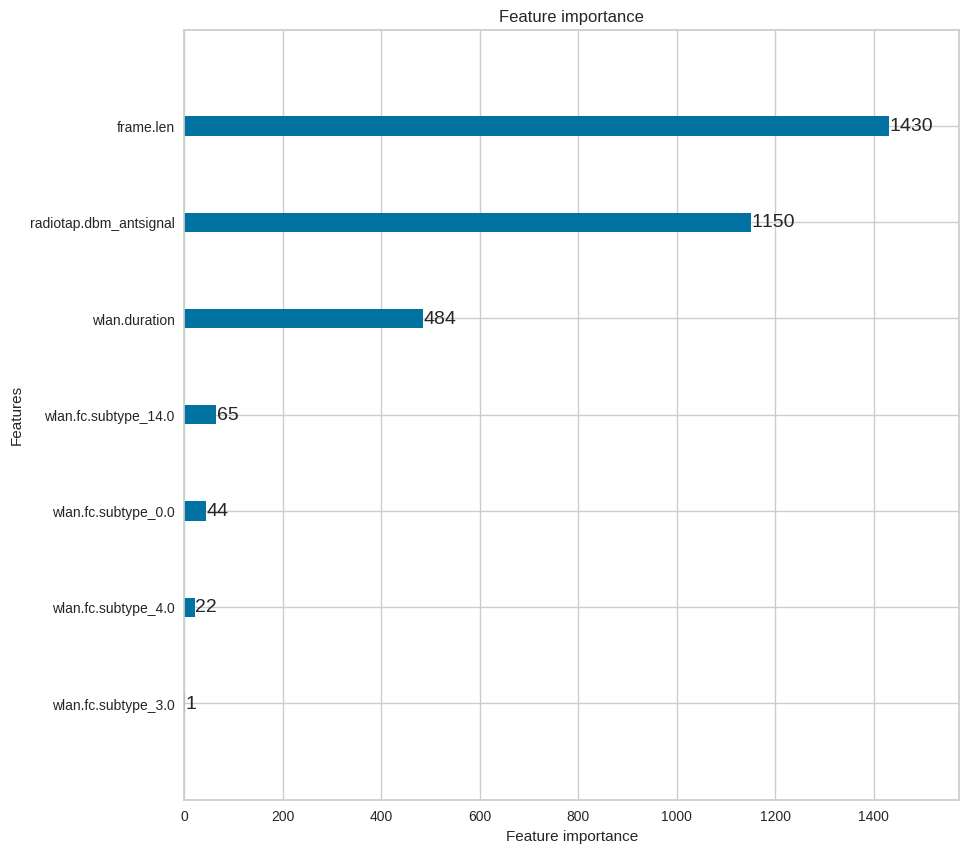

In [12]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99987   0.97557   0.98757     24272
   Evil Twin    0.47476   0.99443   0.64269       539

    accuracy                        0.97598     24811
   macro avg    0.73731   0.98500   0.81513     24811
weighted avg    0.98847   0.97598   0.98008     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99443
False Positive Rate (FPR): 0.02443


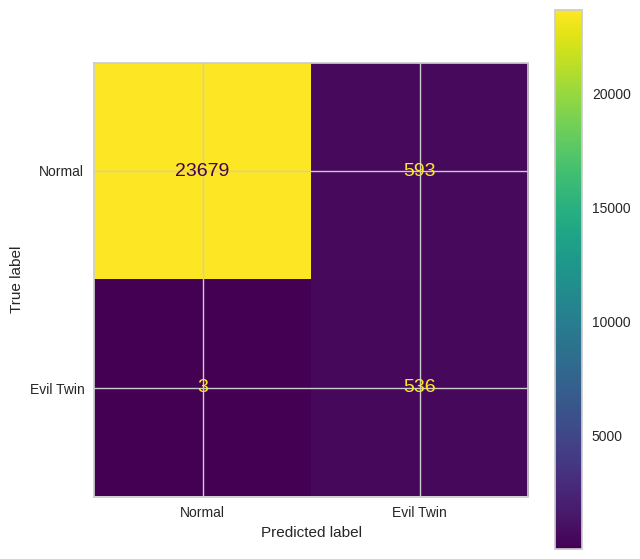

In [13]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_1, y_test, ['Normal', 'Evil Twin'], None)

* **Set 2** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.type*:

In [14]:
# Select column set (wlan.fc.type)
X_res_set_2 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.type')
X_test_set_2 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.type')

In [15]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_2, y_res, 10, 5, models_path, reports_path, 'set_2')

[LightGBM] [Warning] feature_fraction is set=0.5549722516047828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5549722516047828
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.0677439088220676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0677439088220676
[LightGBM] [Warning] bagging_fraction is set=0.20660143502195538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20660143502195538
[LightGBM] [Warning] lambda_l1 is set=1.9090061457092913e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9090061457092913e-05
[LightGBM] [Warning] feature_fraction is set=0.8480259975627881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8480259975627881
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.0877018931

[LightGBM] [Warning] feature_fraction is set=0.26001251826732547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26001251826732547
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.035637476630835274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.035637476630835274
[LightGBM] [Warning] bagging_fraction is set=0.35848135833767647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35848135833767647
[LightGBM] [Warning] lambda_l1 is set=9.723147952344232e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.723147952344232e-05
[LightGBM] [Warning] feature_fraction is set=0.6275314211150529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6275314211150529
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=5.76708727

[LightGBM] [Warning] feature_fraction is set=0.32267466199528294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32267466199528294
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=2.5484204944421993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5484204944421993
[LightGBM] [Warning] bagging_fraction is set=0.6546849520925214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6546849520925214
[LightGBM] [Warning] lambda_l1 is set=0.007903566407091478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007903566407091478
[LightGBM] [Warning] feature_fraction is set=0.7238760418976382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7238760418976382
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.191433269951

[LightGBM] [Warning] feature_fraction is set=0.7658099209531141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7658099209531141
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=1.4783276706888555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4783276706888555e-05
[LightGBM] [Warning] bagging_fraction is set=0.5338083145108425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5338083145108425
[LightGBM] [Warning] lambda_l1 is set=1.4399831652927208e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4399831652927208e-07
[LightGBM] [Warning] feature_fraction is set=0.9863069155302105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9863069155302105
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.1132

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

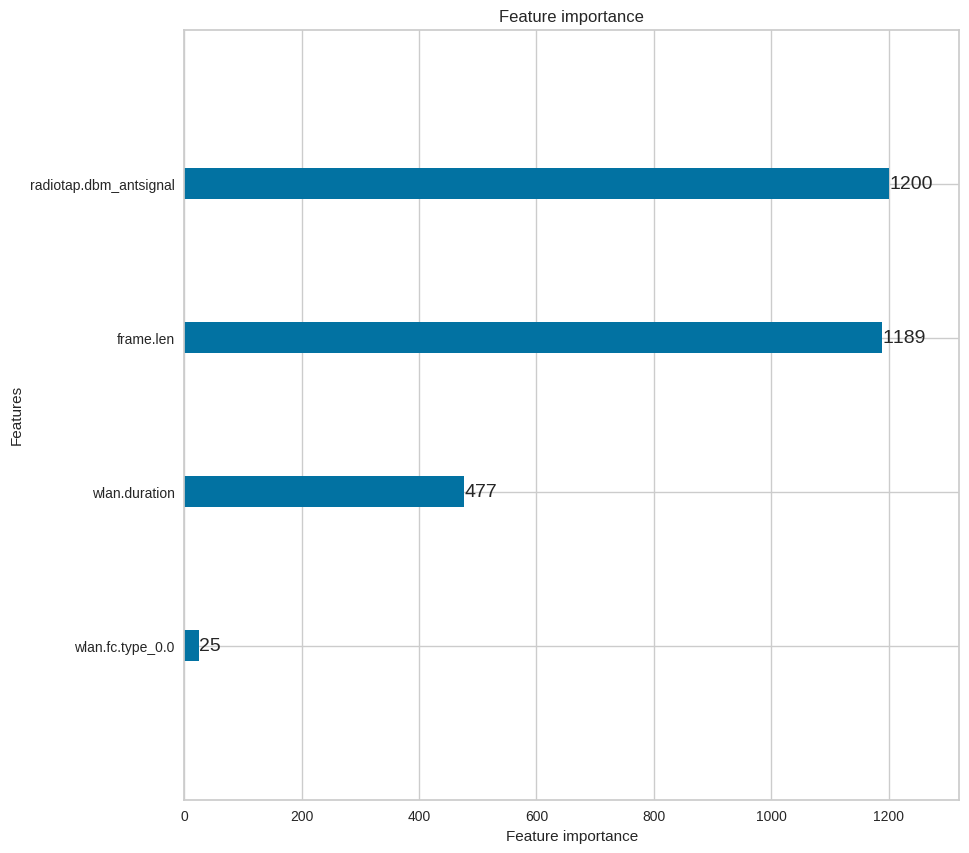

In [16]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99975   0.97174   0.98554     24272
   Evil Twin    0.43724   0.98887   0.60637       539

    accuracy                        0.97211     24811
   macro avg    0.71849   0.98030   0.79596     24811
weighted avg    0.98753   0.97211   0.97731     24811


Confusion Matrix:

True Positive Rate (TPR): 0.98887
False Positive Rate (FPR): 0.02826


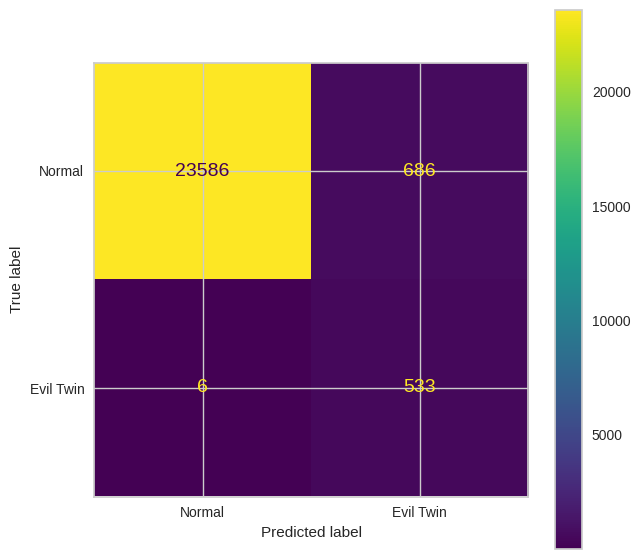

In [17]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_2, y_test, ['Normal', 'Evil Twin'], None)

* **Set 3** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.ds*

In [18]:
# Select column set (wlan.fc.ds)
X_res_set_3 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.ds')
X_test_set_3 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.ds')

In [19]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_3, y_res, 10, 5, models_path, reports_path, 'set_3')

[LightGBM] [Warning] feature_fraction is set=0.19165742790927348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19165742790927348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.09190739978976455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09190739978976455
[LightGBM] [Warning] bagging_fraction is set=0.3964085443829364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3964085443829364
[LightGBM] [Warning] lambda_l1 is set=0.00027155968067904437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027155968067904437
[LightGBM] [Warning] feature_fraction is set=0.6647961507150489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647961507150489
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0419389657

[LightGBM] [Warning] feature_fraction is set=0.4389253424958909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4389253424958909
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9566485011684492e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9566485011684492e-08
[LightGBM] [Warning] bagging_fraction is set=0.9883057364875415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883057364875415
[LightGBM] [Warning] lambda_l1 is set=2.4435995350080713e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4435995350080713e-06
[LightGBM] [Warning] feature_fraction is set=0.9866543671542277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866543671542277
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.000477

[LightGBM] [Warning] feature_fraction is set=0.3246830138824389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3246830138824389
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=0.0002510745440096759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002510745440096759
[LightGBM] [Warning] bagging_fraction is set=0.45302107495354604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45302107495354604
[LightGBM] [Warning] lambda_l1 is set=4.590978434700663e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.590978434700663e-06
[LightGBM] [Warning] feature_fraction is set=0.6647961507150489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647961507150489
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.041938

[LightGBM] [Warning] feature_fraction is set=0.4389253424958909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4389253424958909
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9566485011684492e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9566485011684492e-08
[LightGBM] [Warning] bagging_fraction is set=0.9883057364875415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883057364875415
[LightGBM] [Warning] lambda_l1 is set=2.4435995350080713e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4435995350080713e-06
[LightGBM] [Warning] feature_fraction is set=0.694322890616692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.694322890616692
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.02050651

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

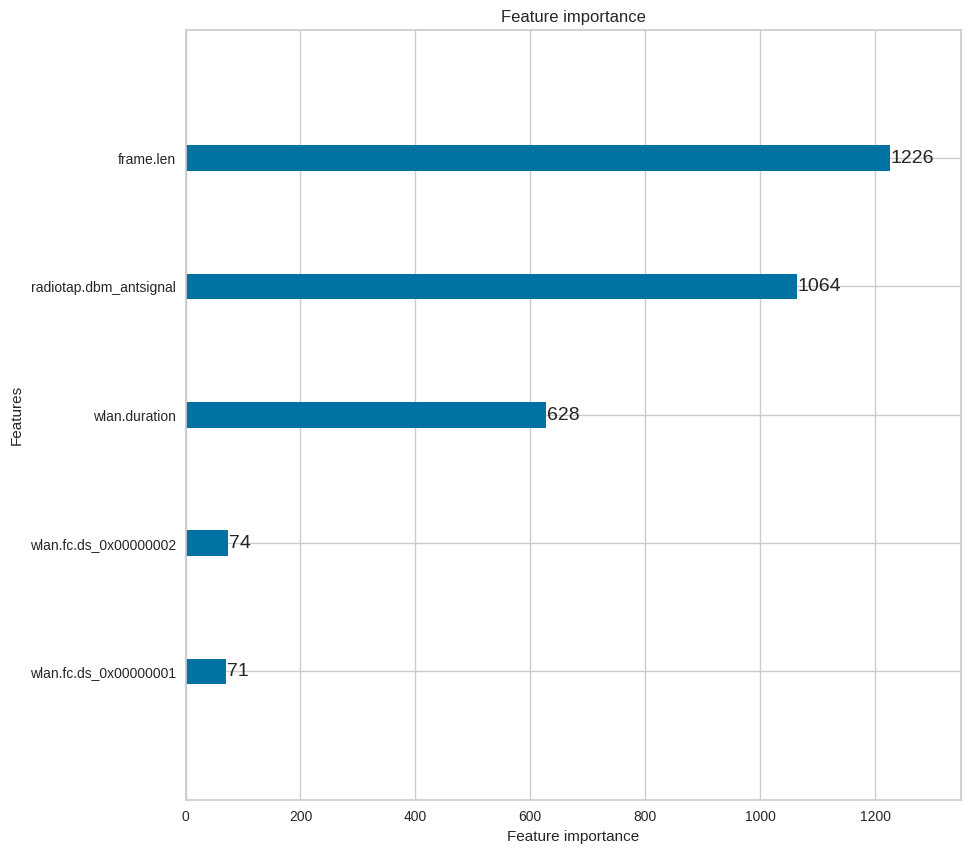

In [20]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99983   0.97573   0.98764     24272
   Evil Twin    0.47598   0.99258   0.64342       539

    accuracy                        0.97610     24811
   macro avg    0.73790   0.98416   0.81553     24811
weighted avg    0.98845   0.97610   0.98016     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99258
False Positive Rate (FPR): 0.02427


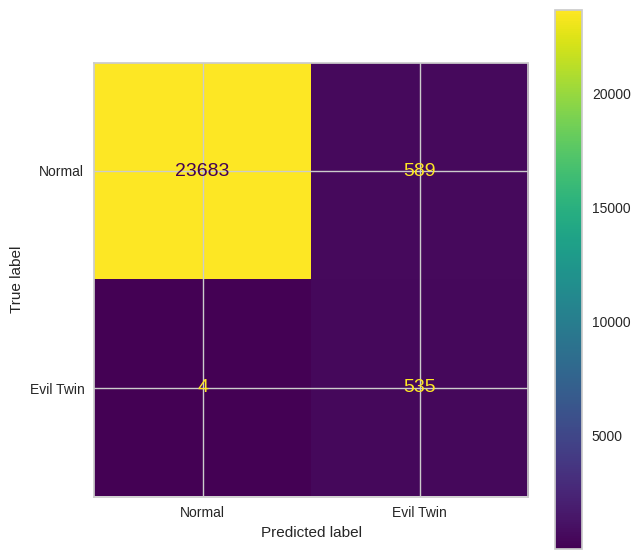

In [21]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_3, y_test, ['Normal', 'Evil Twin'], None)

* **Set 4** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.protected*

In [22]:
# Select column set (wlan.fc.protected)
X_res_set_4 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.protected')
X_test_set_4 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.protected')

In [23]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_4, y_res, 10, 5, models_path, reports_path, 'set_4')

[LightGBM] [Warning] feature_fraction is set=0.6371340713906678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6371340713906678
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.1883356006594443e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1883356006594443e-06
[LightGBM] [Warning] bagging_fraction is set=0.5313696408705919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5313696408705919
[LightGBM] [Warning] lambda_l1 is set=7.664615432450405e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.664615432450405e-06
[LightGBM] [Warning] feature_fraction is set=0.5584518984138988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5584518984138988
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=2.56968691

[LightGBM] [Warning] feature_fraction is set=0.2755438931488159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2755438931488159
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.058345217839938256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.058345217839938256
[LightGBM] [Warning] bagging_fraction is set=0.9285912389800153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285912389800153
[LightGBM] [Warning] lambda_l1 is set=0.6319832240676932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6319832240676932
[LightGBM] [Warning] feature_fraction is set=0.5584518984138988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5584518984138988
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=2.569686911082473e

[LightGBM] [Warning] feature_fraction is set=0.2755438931488159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2755438931488159
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.058345217839938256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.058345217839938256
[LightGBM] [Warning] bagging_fraction is set=0.9285912389800153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285912389800153
[LightGBM] [Warning] lambda_l1 is set=0.6319832240676932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6319832240676932
[LightGBM] [Warning] feature_fraction is set=0.5089243620958055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5089243620958055
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=0.00019194512022

[LightGBM] [Warning] feature_fraction is set=0.8177965463681032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8177965463681032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.3377501608351166e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3377501608351166e-05
[LightGBM] [Warning] bagging_fraction is set=0.3046145292512721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3046145292512721
[LightGBM] [Warning] lambda_l1 is set=1.5416490974872754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5416490974872754
[LightGBM] [Warning] feature_fraction is set=0.4677629294174983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4677629294174983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=2.96550669412525

[LightGBM] [Warning] feature_fraction is set=0.6898808985108492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898808985108492
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.003681131880823755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003681131880823755
[LightGBM] [Warning] bagging_fraction is set=0.41007381775237706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41007381775237706
[LightGBM] [Warning] lambda_l1 is set=1.0056735125351025e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0056735125351025e-06
[LightGBM] [Warning] feature_fraction is set=0.4677629294174983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4677629294174983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=2.96550669

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

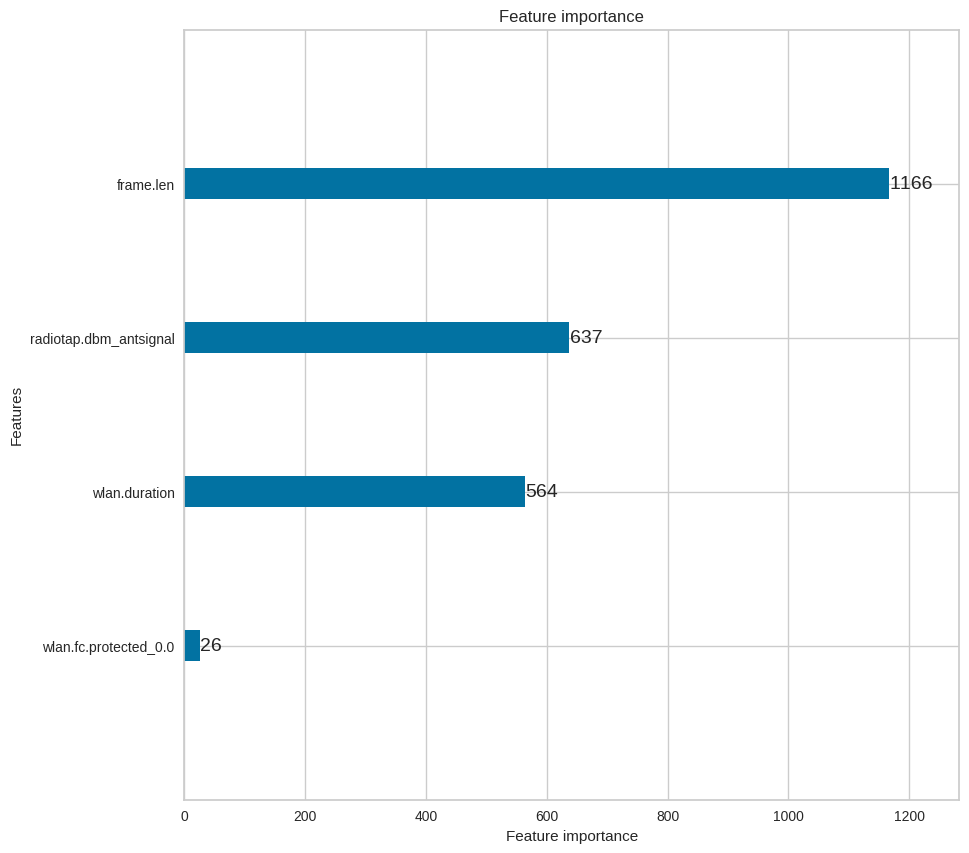

In [24]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99996   0.98896   0.99443     24272
   Evil Twin    0.66749   0.99814   0.80000       539

    accuracy                        0.98916     24811
   macro avg    0.83373   0.99355   0.89721     24811
weighted avg    0.99274   0.98916   0.99020     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99814
False Positive Rate (FPR): 0.01104


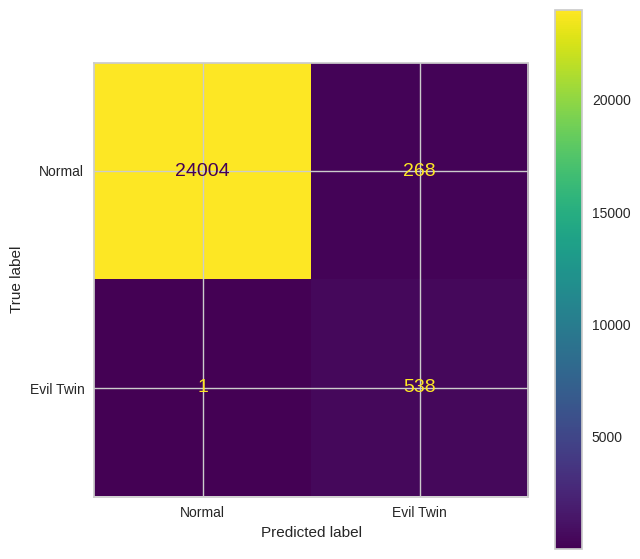

In [25]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_4, y_test, ['Normal', 'Evil Twin'], None)

### Using PyCaret for Automation

Only all columns only.

In [26]:
# Setting up PyCaret
setup = setup(data=train_df, target='Label', fold=5)

,Description,Value
0,Session id,1292
1,Target,Label
2,Target type,Binary
3,Original data shape,"(3147, 24)"
4,Transformed data shape,"(3147, 24)"
5,Transformed train set shape,"(2202, 24)"
6,Transformed test set shape,"(945, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [27]:
# Compare the different models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9923,0.9983,0.9989,0.9822,0.9904,0.9840,0.9841,0.1260
lightgbm,Light Gradient Boosting Machine,0.9918,0.9992,0.9943,0.9854,0.9898,0.9830,0.9830,0.0400
gbc,Gradient Boosting Classifier,0.9914,0.9981,0.9989,0.9800,0.9893,0.9821,0.9822,0.0900
et,Extra Trees Classifier,0.9909,0.9977,0.9955,0.9821,0.9887,0.9811,0.9812,0.1120
xgboost,Extreme Gradient Boosting,0.9909,0.9992,0.9955,0.9821,0.9887,0.9811,0.9812,0.0760
dt,Decision Tree Classifier,0.9891,0.9907,0.9921,0.9809,0.9864,0.9773,0.9774,0.0200
ada,Ada Boost Classifier,0.9887,0.9967,0.9921,0.9799,0.9859,0.9764,0.9765,0.0680
svm,SVM - Linear Kernel,0.9877,0.0000,0.9932,0.9766,0.9848,0.9745,0.9747,0.0180
ridge,Ridge Classifier,0.9868,0.0000,0.9932,0.9744,0.9837,0.9726,0.9728,0.0160
lda,Linear Discriminant Analysis,0.9868,0.9916,0.9932,0.9744,0.9837,0.9726,0.9728,0.0220


In [28]:
# Select one of the templates to generate
# Here 'lightgbm' will be used
creat_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9932,0.9987,0.9944,0.9888,0.9915,0.9859,0.9859
1,0.9932,0.9988,1.0000,0.9832,0.9915,0.9859,0.9860
2,0.9909,0.9998,0.9943,0.9831,0.9887,0.9811,0.9811
3,0.9955,1.0000,0.9943,0.9943,0.9943,0.9905,0.9905
4,0.9864,0.9987,0.9886,0.9775,0.9831,0.9716,0.9717
Mean,0.9918,0.9992,0.9943,0.9854,0.9898,0.9830,0.9830
Std,0.0031,0.0006,0.0036,0.0057,0.0038,0.0064,0.0064


In [29]:
# Evaluate the selected model
evaluate_model(creat_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
# Optimize the hyperparameters of the generated model
tuned = tune_model(creat_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9955,0.9980,1.0000,0.9888,0.9944,0.9906,0.9906
1,0.9819,0.9990,0.9830,0.9719,0.9774,0.9623,0.9623
2,0.9886,0.9998,0.9943,0.9777,0.9859,0.9764,0.9765
3,0.9955,1.0000,1.0000,0.9888,0.9944,0.9905,0.9906
4,0.9841,0.9981,0.9886,0.9721,0.9803,0.9669,0.9670
Mean,0.9891,0.9990,0.9932,0.9798,0.9865,0.9773,0.9774
Std,0.0056,0.0008,0.0066,0.0076,0.0070,0.0117,0.0117


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


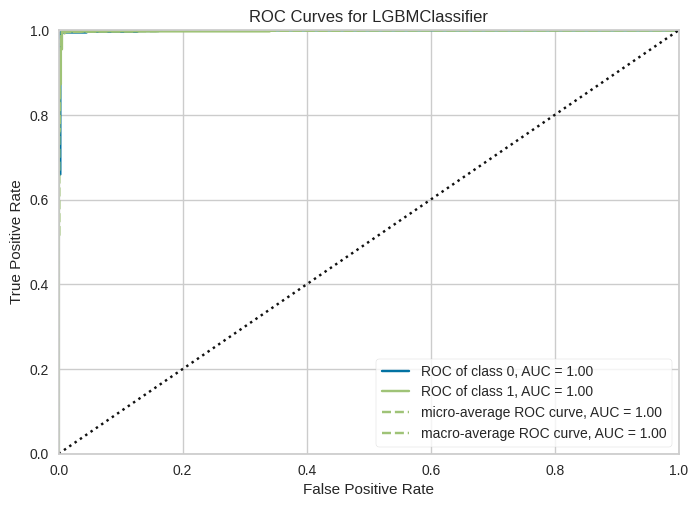

In [31]:
# ROC curve
plot_model(creat_model)

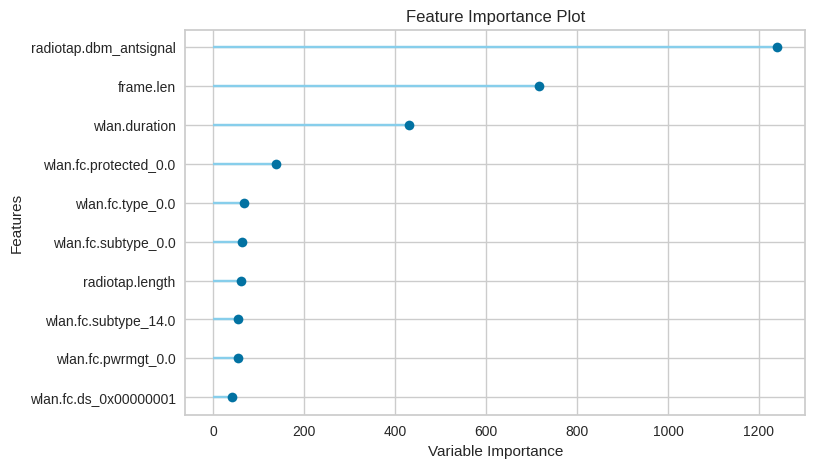

In [32]:
# Feature importance
plot_model(creat_model, plot='feature')

In [33]:
# Save the model
save_model(creat_model, f'{models_path}lightgbm_all_pycaret');

Transformation Pipeline and Model Successfully Saved
